In [1]:
## Make sure plots are create inline
%matplotlib inline
## The usual packages (numpy, matplotlib, etc)
from RSE_style import *
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
from mpl_toolkits.basemap import Basemap
import h5py as h5
import os
from scipy.interpolate import UnivariateSpline
from IPython.display import clear_output

In [2]:
# Get SIF shape with grid
f = h5.File('/Users/owinton/Documents/TROPOMI/PS_SIF_map.h5','r')
SIF_spec = f['SIF_shape'][:]
SIF_wl = f['wlGrid'][:]
f.close()

### Getting the Principal Components from SVD

#### Task 1. Get a lot of SIF-free spectra for each detector spatial pixel

In [3]:
directory = '/Users/owinton/Documents/TROPOMI/TROPOMI_SAHARA/'
nspec = 150
spec_pixel_all = np.zeros((408, 150, 497))
wl_pixel_all = np.zeros((408, 497))
count = np.zeros((408))
samplelat = np.zeros((408, 150))
samplelon = np.zeros((408, 150))


# Check each file
for filename in os.listdir(directory):
    if filename.endswith('.zip'):
        file_nadir = os.path.join(directory, filename)
        print(file_nadir)
        fn = h5.File(file_nadir)
        lat = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/latitude'][0,:,:]
        lon = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/longitude'][0,:,:]
        sza = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/solar_zenith_angle'][0,:,:]
        wl_spec = fn['BAND6_RADIANCE/STANDARD_MODE/INSTRUMENT/nominal_wavelength'][0,:,:]
        spec = fn['BAND6_RADIANCE/STANDARD_MODE/OBSERVATIONS/radiance'][0,:,:,:]
        fn.close()
        
        # For each pixel
        for i in range(408):
            wl_pixel_all[i, :] = wl_spec[i+20, :]
            # Check each swath
            for j in range(np.shape(lat)[0]):
                if (lat[j, i+20] > 18 and lat[j,i+20] < 28 and lon[j,i+20] > -8 and lon[j,i+20] < 28 and sza[j, i+20] < 60 and count[i] < 150):
                    spec_pixel_all[i, int(count[i]), :] = spec[j, i+20, :]
                    samplelat[i, int(count[i])] = lat[j,i+20]
                    samplelon[i, int(count[i])] = lon[j,i+20]
                    count[i] += 1
                    


/Users/owinton/Documents/TROPOMI/TROPOMI_SAHARA/S5P_OFFL_L1B_RA_BD6_20181012T102851_20181012T121021_05165_01_010000_20181012T140022.zip
/Users/owinton/Documents/TROPOMI/TROPOMI_SAHARA/S5P_OFFL_L1B_RA_BD6_20181012T121021_20181012T135150_05166_01_010000_20181012T154030.zip


Text(0.5,1,'Solar spectrum sample area')

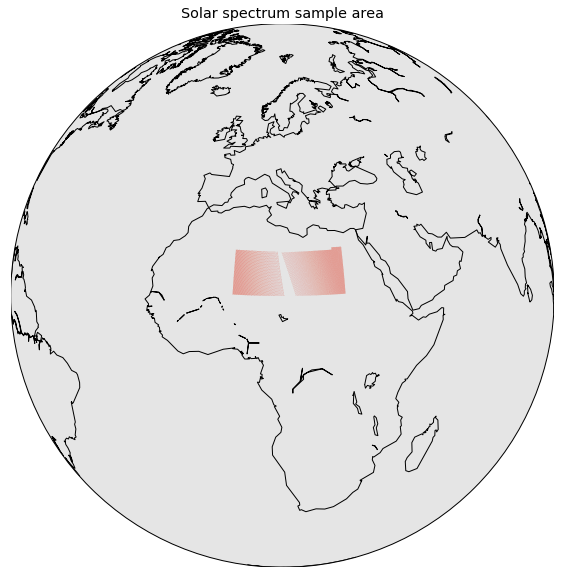

In [4]:
m = Basemap(projection='ortho', lon_0=14, lat_0=18, resolution='c')
figsize(16,10)
m.scatter(samplelon, samplelat, 0.0001, marker='D', latlon=True)
m.drawcoastlines()
plt.title('Solar spectrum sample area')

In [5]:
spec_pixel_all_backup = spec_pixel_all.copy()
wl_pixel_all_backup = wl_pixel_all.copy()
print(spec_pixel_all_backup.shape, wl_pixel_all_backup.shape)

(408, 150, 497) (408, 497)


In [6]:
# Get the first 122 wavelengths above 743 nm, this is our retrieval area. Same amount of spectral values to make matrices easier
# Get rid of 20 pixels at each edge as well
spec_pixel_trunc = np.zeros((408, 150, 122))
wl_pixel_trunc = np.zeros((408, 122))
for i in range(408):
    index_pixel = wl_pixel_all[i, :] > 743
    wl_pixel = wl_pixel_all[i, index_pixel]
    wl_pixel_trunc[i, :] = wl_pixel[:122]
    for j in range(150):
        spec_pixel = spec_pixel_all[i, j, index_pixel]
        spec_pixel_trunc[i, j, :] = spec_pixel[:122]

#### Task 2.  Do the SVD and show some of the PC-functions and their explained variance

In [7]:
u = np.zeros((408, 150, 150))
s = np.zeros((408, 122))
vh = np.zeros((408, 122, 122))
for i in range(408):
    u[i,:,:], s[i,:], vh[i,:,:] = np.linalg.svd(spec_pixel_trunc[i, :, :])

[1.27592984e-04 2.42058642e-07 5.64126819e-08 3.99434892e-08
 1.41382664e-08]


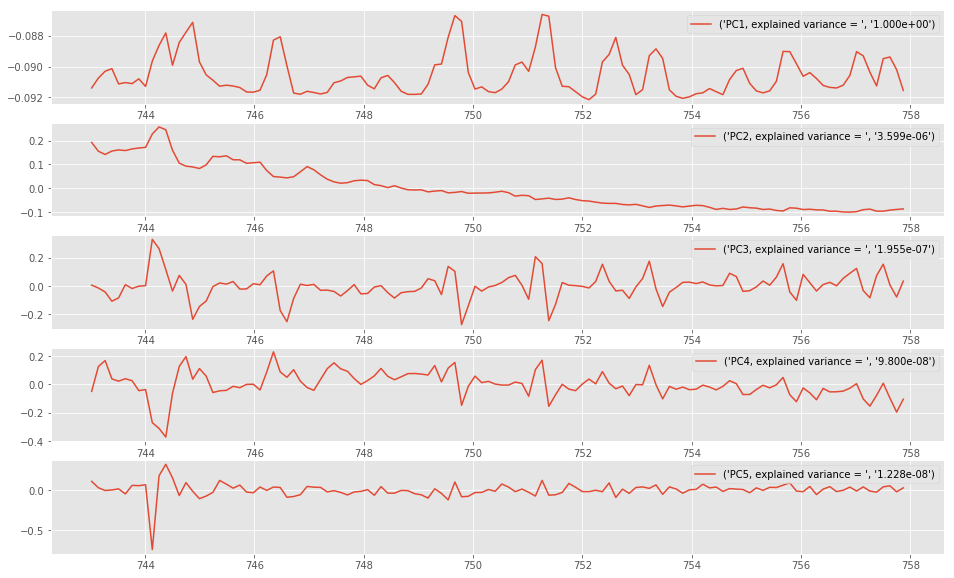

In [8]:
plt.subplot(511)
test_pixel = 1
plt.plot(wl_pixel_trunc[test_pixel,:],vh[test_pixel,0,:],label=('PC1, explained variance = ', '{:0.3e}'.format(s[test_pixel,0]**2/(s[test_pixel,:].dot(s[test_pixel,:].T)))))
plt.legend(loc=1)
#plt.yticks([])
plt.subplot(512)
plt.plot(wl_pixel_trunc[test_pixel,:],vh[test_pixel,1,:],label=('PC2, explained variance = ', '{:0.3e}'.format(s[test_pixel,1]**2/(s[test_pixel,:].dot(s[test_pixel,:].T)))))
plt.legend(loc=1)
#plt.yticks([])
plt.subplot(513)
plt.plot(wl_pixel_trunc[test_pixel,:],vh[test_pixel,2,:],label=('PC3, explained variance = ', '{:0.3e}'.format(s[test_pixel,2]**2/(s[test_pixel,:].dot(s[test_pixel,:].T)))))
plt.legend(loc=1)
#plt.yticks([])
plt.subplot(514)
plt.plot(wl_pixel_trunc[test_pixel,:],vh[test_pixel,3,:],label=('PC4, explained variance = ', '{:0.3e}'.format(s[test_pixel,3]**2/(s[test_pixel,:].dot(s[test_pixel,:].T)))))
plt.legend(loc=1)
#plt.yticks([])
plt.subplot(515)
plt.plot(wl_pixel_trunc[test_pixel,:],vh[test_pixel,4,:],label=('PC5, explained variance = ', '{:0.3e}'.format(s[test_pixel,4]**2/(s[test_pixel,:].dot(s[test_pixel,:].T)))))
plt.legend(loc=1)

print(s[test_pixel,0:5])


Prior covariance proportional to their eigenvalue. Get mean of PC1 from U * S * V
Noisemodel: sqrt(irradiance) * scaling factor
0.06475 + 0.03721 * sqrt(cont)

#### Let's get retrievals started

In [9]:
# Forward model defined based upon Köhler (2018) supplement eq. 1
def ForwardModel(x, PC, wl_grid, SIF, compK = False):
    # Unnecessary, but makes comparison to Köhler easier
    gam1, gam2, gam3, gam4, gam5 = x[0], x[1], x[2], x[3], x[4]
    eta1, eta2, eta3 = x[5], x[6], x[7]
    Fs = x[8]
    P1 = wl_grid
    P2 = 1/2*(3*wl_grid**2-1)
    P3 = 1/2*(5*wl_grid**3-3*wl_grid)
    
    sun = gam1 * PC[0] + gam2 * PC[1] + gam3 * PC[2] + gam4 * PC[3] + gam5 * PC[4]
    leg = eta1 * P1 * PC[0] + eta2 * P2 * PC[0] + eta3 * P3 * PC[0]
    sif = Fs * SIF
    
    Ftoa = sun + leg + sif
    if compK == True:
        K = np.zeros((122, 9))
        K[:, 0] = PC[0, :]
        K[:, 1]= PC[1, :]
        K[:, 2] = PC[2, :]
        K[:, 3] = PC[3, :]
        K[:, 4] = PC[4, :]
        K[:, 5] = P1*PC[0, :]
        K[:, 6] = P2*PC[0, :]
        K[:, 7] = P3*PC[0, :]
        K[:, 8] = SIF
        return Ftoa, K
    else:
        return Ftoa
    

### Testing retrieval on Sahara pixels

In [10]:
#           Ndata, Nparameters
spl = UnivariateSpline(SIF_wl, SIF_spec, k=3, s=0)
# Factor for weighing the singular value of PC1:4 in terms of variance
factor = 1
xhat = np.zeros((408, 150, 9))
residuals = np.zeros((408, 150, 122))
xa = np.zeros((9,))
for i in range(408):
    # Singular values for this pixel
    
    sv = s[i,0:5]
    Sa = np.array([1e20, factor*sv[1], factor*sv[2], factor*sv[3], factor*sv[4], 1e20, 1e20, 1e20, 1e20])
    invSa = np.diag(1/Sa)
    PC = vh[i, 0:6, :]
    wl_grid = wl_pixel_trunc[i, :]
    SIF = spl(wl_grid)
    F, K = ForwardModel(np.zeros(9), PC, wl_grid, SIF, True)
    for j in range(150):
        spec = spec_pixel_trunc[i, j]
        noise = 0.06475 + 0.03721 * np.sqrt(spec)
        invSe = np.diag(1/noise**2)
        
        xhat[i, j, :] = np.linalg.inv( K.T.dot(invSe).dot(K) + invSa ).dot( (K.T).dot(invSe).dot(spec) + invSa.dot(xa) )
        residuals[i, j, :] = spec - ForwardModel(xhat[i, j, :], PC, wl_grid, SIF)
        

Text(0.5,1,'SIF retrievals')

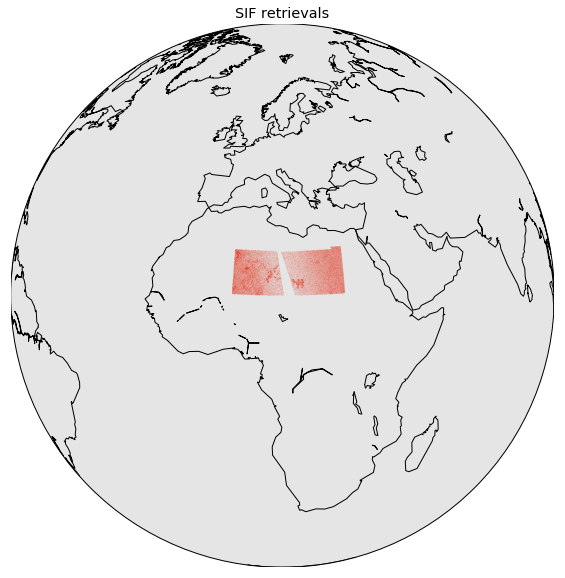

In [11]:
SIF_retrievals = xhat[:, :, 8]
m = Basemap(projection='ortho', lon_0=14, lat_0=18, resolution='c')
figsize(16,10)
m.scatter(samplelon, samplelat, 1e14*SIF_retrievals**2, marker='D', latlon=True)
m.drawcoastlines()
plt.title('SIF retrievals')


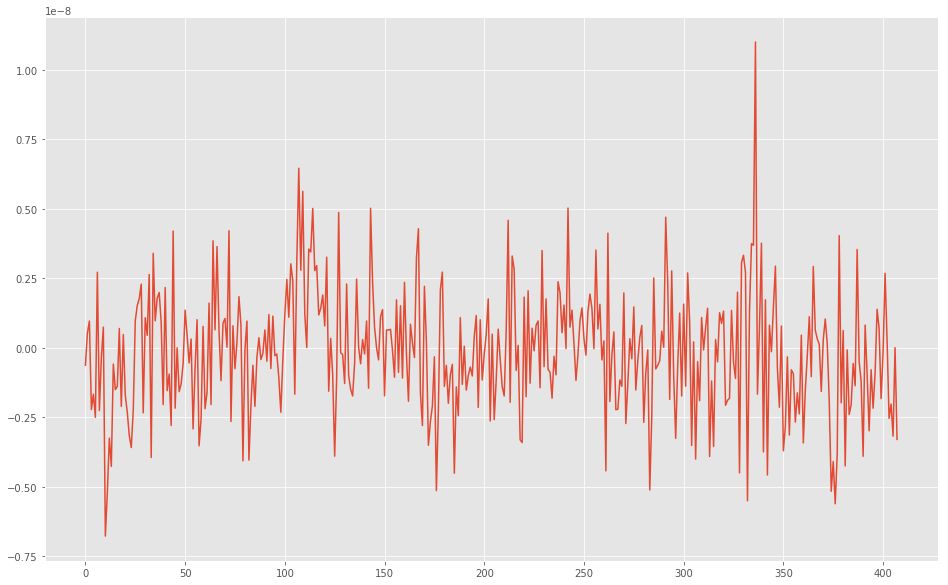

In [12]:
plt.plot(SIF_retrievals[:,0])

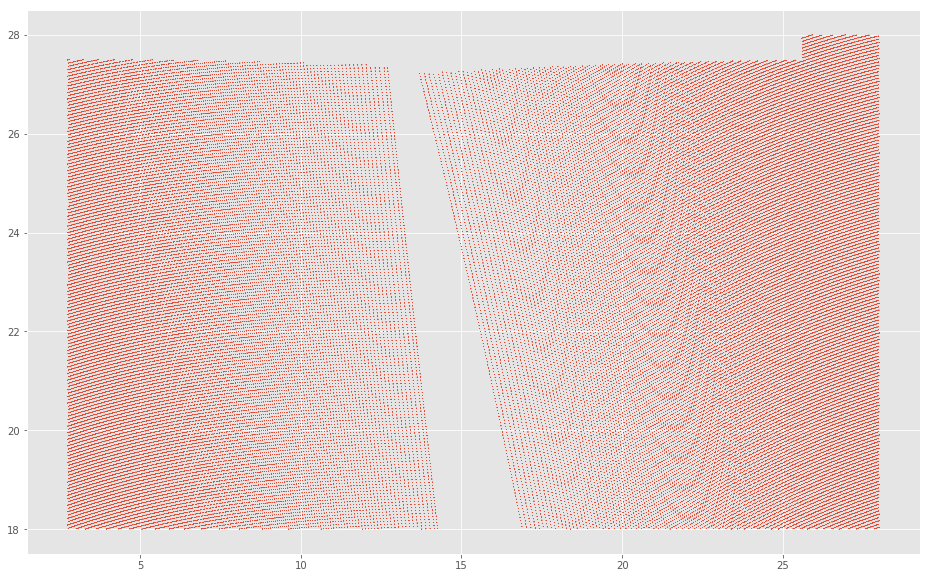

In [13]:
plt.scatter(samplelon, samplelat, SIF_retrievals**2)


## Trying one file at a time

In [44]:
directory = '/Users/owinton/Documents/TROPOMI/TROPOMI_SAHARA'
filename = 'S5P_OFFL_L1B_RA_BD6_20181012T102851_20181012T121021_05165_01_010000_20181012T140022.zip'
file_nadir = os.path.join(directory, filename)
fn = h5.File(file_nadir)
lat = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/latitude'][0,:,20:428]
lon = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/longitude'][0,:,20:428]
sza = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/solar_zenith_angle'][0,:,20:428]
wl_spec = fn['BAND6_RADIANCE/STANDARD_MODE/INSTRUMENT/nominal_wavelength'][0,20:428,:]
spec = fn['BAND6_RADIANCE/STANDARD_MODE/OBSERVATIONS/radiance'][0,:,20:428,:]
fn.close()

In [45]:
np.min(spec.flatten())

-3.8380338e-10

In [15]:
print(lat.shape, lon.shape, sza.shape, wl_spec.shape, spec.shape)

(3245, 408) (3245, 408) (3245, 408) (408, 497) (3245, 408, 497)


In [16]:
# Get the first 122 wavelengths above 743 nm, this is our retrieval area. Same amount of spectral values to make matrices easier
# Get rid of 20 pixels at each edge as well
spec_pixel_trunc = np.zeros((lat.shape[0], 408, 122))
wl_pixel_trunc = np.zeros((408, 122))
for i in range(408):
    index_pixel = wl_spec[i, :] > 743
    wl_pixel = wl_spec[i, index_pixel]
    wl_pixel_trunc[i, :] = wl_pixel[:122]
    for j in range(lat.shape[0]):
        spec_pixel = spec[j, i, index_pixel]
        spec_pixel_trunc[j, i, :] = spec_pixel[:122]
wl_spec = wl_pixel_trunc
spec = spec_pixel_trunc

In [30]:
spl = UnivariateSpline(SIF_wl, SIF_spec, k=3, s=0)
# Factor for weighing the singular value of PC1:4 in terms of variance
factor = 1
                     #swaths        #pixels #state vector elements
xhat = np.zeros((lat.shape[0], lat.shape[1], 9))
residuals = np.zeros((lat.shape[0], lat.shape[1], 122))
# Prior
xa = np.zeros((9,))
# For each pixel
for pixel in range(408):
    # Singular values for this pixel
    sv = s[pixel,0:5]
    # Prior for this pixel
    Sa = np.array([1e20, factor*sv[1], factor*sv[2], factor*sv[3], factor*sv[4], 1e20, 1e20, 1e20, 1e20])
    invSa = np.diag(1/Sa)
    # Principal component functions for this pixel
    PC = vh[pixel, 0:6, :]
    # Wavelength grid for this pixel
    wl_grid = wl_spec[pixel, :]
    # SIF-shape interpolated to wavelength grid of this pixel
    SIF = spl(wl_grid)
    # Get the Jacobian K
    F, K = ForwardModel(np.zeros(9), PC, wl_grid, SIF, True)
    for swath in range(100):#(lat.shape[0]):
        noise = 0.06475 + 0.03721 * np.sqrt(spec[swath, pixel, :])
        invSe = np.diag(1/noise**2)
        spec_it = spec[swath, pixel, :]
        xhat[swath, pixel, :] = np.linalg.inv( K.T.dot(invSe).dot(K) + invSa ).dot( (K.T).dot(invSe).dot(spec_it) + invSa.dot(xa) )
        residuals[swath, pixel, :] = spec_it - ForwardModel(xhat[swath, pixel, :], PC, wl_grid, SIF)
    clear_output(wait=True)
    print("Current progress",np.round((pixel/408) * 100, 1), "%")

   

Current progress 99.8 %


In [43]:
spec[swath, pixel, :]

array([ 8.81150014e-11,  3.82432974e-11, -1.70688824e-10,  5.68796087e-11,
        8.85104143e-11,  1.31508193e-10,  6.99464375e-11,  1.50216450e-10,
       -9.66994332e-11,  1.15534372e-12, -4.40210932e-12,  5.71057368e-11,
       -4.13028049e-11, -5.45223797e-11,  5.14611097e-11,  1.97803631e-11,
        1.42190947e-11,  2.62074973e-10,  3.28883136e-11, -9.15089185e-11,
        8.88753932e-11, -1.73749730e-11,  3.29638851e-11,  1.13442526e-10,
       -1.15451620e-10, -3.60185805e-11,  5.17918694e-11,  9.47355944e-11,
        8.91922369e-11,  7.61518903e-11,  5.17274036e-11, -1.73853328e-11,
        7.05747752e-11, -1.85405094e-10,  1.26655172e-10,  1.99945355e-11,
       -1.15962191e-10, -1.74113883e-11,  1.83192961e-10, -1.74051711e-11,
       -4.17360833e-11,  1.25690647e-12, -7.90037757e-11, -1.74483084e-11,
        1.43705742e-11,  5.77239576e-11, -4.18086156e-11,  2.00642263e-11,
        1.43750142e-11, -3.63382067e-11,  8.97238256e-11,  1.89915611e-10,
       -6.04499922e-11,  

In [41]:
np.diag(invSe)

array([238.51503973, 238.51591774,          nan, 238.51554553,
       238.51503396, 238.51446933, 238.51532032, 238.51425315,
                nan, 238.51731837,          nan, 238.51554143,
                nan,          nan, 238.51564647, 238.5163938 ,
       238.51657931, 238.51317514, 238.5160409 ,          nan,
       238.51502865,          nan, 238.5160391 , 238.51469323,
                nan,          nan, 238.51564017, 238.5149448 ,
       238.51502405, 238.51522078, 238.51564139,          nan,
       238.51531005,          nan, 238.51452788, 238.51638722,
                nan,          nan, 238.51390264,          nan,
                nan, 238.51730569,          nan,          nan,
       238.51657382, 238.51553024,          nan, 238.51638509,
       238.51657366,          nan, 238.51501634, 238.51383518,
                nan, 238.5149283 , 238.51475484,          nan,
                nan, 238.51589681,          nan,          nan,
       238.51657038,          nan,          nan,       

In [35]:
xhat[swath,pixel,:]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan])

Text(0.5,1,'SIF retrievals')

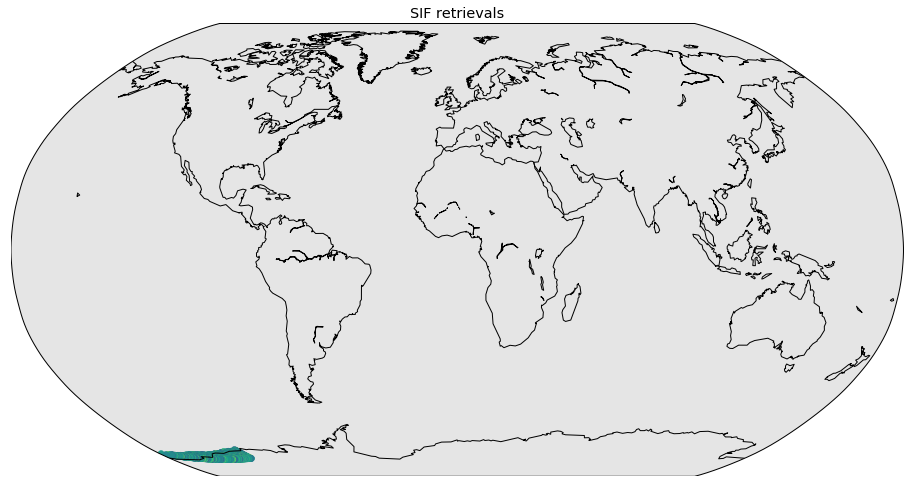

In [23]:
SIF_retrievals = xhat[:, :, 8]
m = Basemap(projection='robin', lon_0=0, resolution='c')
figsize(16,10)
m.scatter(lon[0:100, :], lat[0:100,:], s = None, c = SIF_retrievals[0:100, :], latlon=True)
m.drawcoastlines()
plt.title('SIF retrievals')


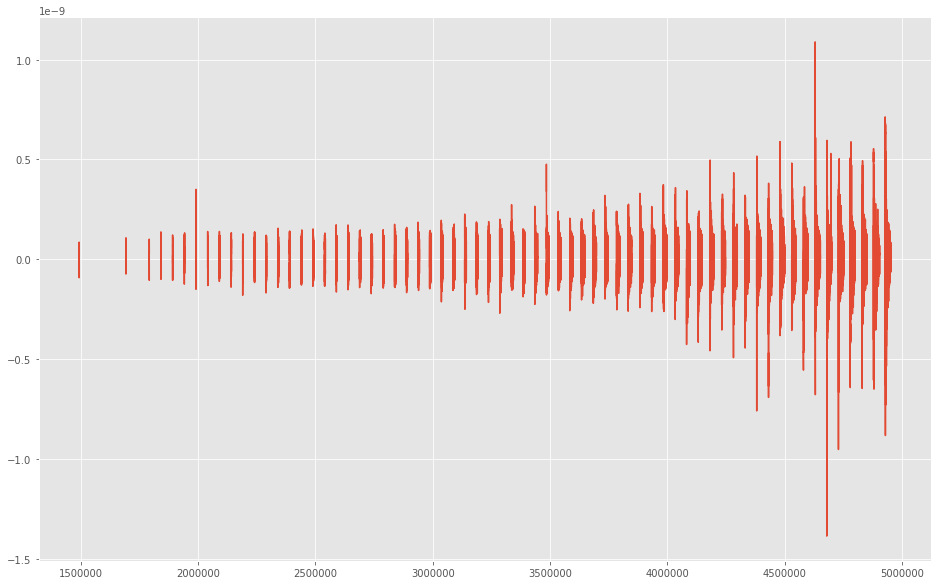

In [25]:
plt.plot(residuals[0:100, :].flatten())